# Import packages


In [1]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np
import pandas as pd
# from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set the device to GPU if available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# ! pip install pyarrow fastparquet tqdm seaborn torch

In [4]:
# # Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

In [5]:
# load data
ts = pd.read_pickle('data/test/counts_yellow_2023-01_2023-03.pkl')
# ts = pd.read_pickle('./drive/MyDrive/Data Science Projects/taxi-forecast/notebooks/data/test/counts_yellow_2023-01_2023-03.pkl')


# Preprocess data for modelling

Uncomment the print lines to check the tensors and their dimensions

In [6]:
# Drop zone with very sparse time series
n_top_zones = 50
n_bottom_zones = 100
selected_zones_df = ts.groupby('PULocationID')['counts'].sum().sort_values(ascending=False)[:-n_bottom_zones]
display(selected_zones_df)
selected_zones = selected_zones_df.index.to_list()

PULocationID
132    461946.0
237    436955.0
161    431690.0
236    404143.0
162    332451.0
         ...   
63        346.0
139       338.0
26        337.0
210       331.0
198       328.0
Name: counts, Length: 162, dtype: float64

In [71]:
ts[ts["PULocationID"] == 3]

PULocationID           pickup_datetime  counts
1488               3 2023-01-01 00:00:00-05:00     0.0
1489               3 2023-01-01 01:00:00-05:00     0.0
1490               3 2023-01-01 02:00:00-05:00     0.0
1491               3 2023-01-01 03:00:00-05:00     0.0
1492               3 2023-01-01 04:00:00-05:00     0.0
...              ...                       ...     ...
366808             3 2023-03-31 19:00:00-04:00     1.0
366809             3 2023-03-31 20:00:00-04:00     0.0
366810             3 2023-03-31 21:00:00-04:00     1.0
366811             3 2023-03-31 22:00:00-04:00     0.0
366812             3 2023-03-31 23:00:00-04:00     0.0

[2159 rows x 3 columns]

In [74]:
# Filter data with selected zones
# ts_2 = ts[ts['PULocationID'].isin([56, 79, 120])].copy()
ts_2 = ts[ts['PULocationID'].isin(selected_zones)].copy()
display(ts_2.head())

# Remap zone ID to [0, 1, 2,...] in order to work with nn.Embedding()
zone_list = sorted(list(ts_2['PULocationID'].unique()))
zone_dict = dict(zip(zone_list, range(len(zone_list))))
ts_2['zone_id'] = ts['PULocationID'].map(zone_dict)

# Pivot wide: each colunm is a time series of a zone
ts_multi = ts_2.pivot(index='pickup_datetime', columns= 'zone_id',  values = 'counts')
display(ts_multi.head())
ts_multi.columns

PULocationID           pickup_datetime  counts
0             1 2023-01-01 00:00:00-05:00     0.0
1             1 2023-01-01 01:00:00-05:00     0.0
2             1 2023-01-01 02:00:00-05:00     0.0
3             1 2023-01-01 03:00:00-05:00     0.0
4             1 2023-01-01 04:00:00-05:00     0.0

zone_id                    0.0    1.0    2.0    3.0    4.0    5.0    6.0    \
pickup_datetime                                                              
2023-01-01 00:00:00-05:00    0.0   19.0    3.0    0.0    1.0   14.0    0.0   
2023-01-01 01:00:00-05:00    0.0   28.0   16.0    0.0    1.0   18.0    0.0   
2023-01-01 02:00:00-05:00    0.0   43.0   28.0    1.0    0.0   11.0    0.0   
2023-01-01 03:00:00-05:00    0.0   33.0   21.0    0.0    0.0    7.0    1.0   
2023-01-01 04:00:00-05:00    0.0   12.0   12.0    1.0    0.0    6.0    1.0   

zone_id                    7.0    8.0    9.0    ...  152.0  153.0  154.0  \
pickup_datetime                                 ...                        
2023-01-01 00:00:00-05:00    0.0   20.0    4.0  ...  163.0    0.0   11.0   
2023-01-01 01:00:00-05:00    7.0   12.0   12.0  ...   98.0    0.0   34.0   
2023-01-01 02:00:00-05:00    7.0   13.0   12.0  ...  124.0    0.0   38.0   
2023-01-01 03:00:00-05:00    4.0    5.0    8.0  ...  125.0    1.0   25.0   
2023-01-01 04:00:00-05:00    2.0   11.0    1.0  ...   92.0    1.0   15.0   

zone_id                    155.0  156.0  157.0  158.0  159.0  160.0  161.0  
pickup_datetime                                                             
2023-01-01 00:00:00-05:00   11.0    1.0   13.0   66.0  212.0   72.0    5.0  
2023-01-01 01:00:00-05:00   27.0    2.0   21.0   51.0  242.0   60.0   10.0  
2023-01-01 02:00:00-05:00   24.0    6.0   31.0   28.0  188.0   59.0    8.0  
2023-01-01 03:00:00-05:00   35.0    3.0   16.0   14.0  123.0   53.0    8.0  
2023-01-01 04:00:00-05:00   10.0    2.0    9.0   13.0   54.0   27.0    4.0  

[5 rows x 162 columns]

Index([  0.0,   1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,
       ...
       152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0],
      dtype='float64', name='zone_id', length=162)

In [75]:
# Function to reindex the list of sequences --> resulting re-indexed list of sequence is ready to be batched while maintain the time line through batches
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = []
    for i in range(m):
        re_indexed_batch = list(ds[i + m*j] for j in range(bs))
        # print('batch length: ', len(re_indexed_batch))
        new_ds += list(ds[i + m*j] for j in range(bs))
    return new_ds

In [76]:
data = ts_multi

print(type(data))
print(data.shape)
# print(data)
print()

# Normalize data - standardize each column independently
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
print(type(data))
print(data.shape)
# print(data)
print()

# Transpose --> each row is a time series for a given zone
data = data.T
print(type(data))
print(data.shape)
print()

# Convert data to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
print(type(data))
print(data.shape)
print()
display(data)


<class 'pandas.core.frame.DataFrame'>
(2159, 162)

<class 'numpy.ndarray'>
(2159, 162)

<class 'numpy.ndarray'>
(162, 2159)

<class 'torch.Tensor'>
torch.Size([162, 2159])



tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
        [0.2468, 0.3636,  ..., 0.1818, 0.2208],
        ...,
        [0.4706, 0.3922,  ..., 0.4837, 0.4118],
        [0.2273, 0.4545,  ..., 0.0455, 0.3182]], device='cuda:0')

In [80]:
data[:, 1704:]

torch.Size([162, 455])

In [77]:
sl = 24 # size of each slide (over time)
batch_size = len(zone_list) # This is the number of zones

# Prepare the data into list of sequences (pair of input and target sequences)
data_pp = []  # this will be a list of lists, each inner list contain the slides of a given time series
for r in range(len(data)):
    # print(r)
    series_pp = [(data[r][i:i+sl], data[r][i+1:i+sl+1]) for i in range(0,len(data[r])-sl-1,sl)]
    # print('type of series_pp: ', type(series_pp))
    data_pp.append(series_pp)
    # print('N samples in the series: ', len(series_pp))
    # print('First sample in the series: ', series_pp[0])
    # print('Second sample in the series: ', series_pp[1])
    # print()

# Create Train and Validation sets - fix cutoff index to drop last few obs that are not enough to formm a batch
cut = int(len(data_pp[0]) * 0.8)

train_data = [s[:cut] for s in data_pp]
valid_data = [s[cut:] for s in data_pp]
 
# print('length of train_data: ', len(train_data))
# print('length of each series in train_data: ', len(train_data[0]))
# print('first item of train_data[0]: ', train_data[0][0])
print('length of each series in valid_data: ', len(valid_data[0]))
# print()

# Concatenate the 3 series into a long chain
train_set = [i for s in train_data for i in s ]
valid_set = [i for s in valid_data for i in s ]
# print('length of concat train set: ', len(train_set))
# print('length of concat valid set: ', len(valid_set))
# print('first item of train_set[0]: ', train_set[0])
# print()

# Reindex with group_chunks() --> Concatenate & Reindex helps with dataloader which takes in a list
train_set = group_chunks(train_set, batch_size)
valid_set = group_chunks(valid_set, batch_size)
# print('length of reindexed train set: ', len(train_set))
# print('length of reindexed valid set: ', len(valid_set))
# print()


71
length of each series in valid_data:  18


In [11]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# # Check size of Train and Validation sets in the dataloaders
# print('N batches in train loader: ', len(list(train_loader)))
# print('N batches in valid loader: ', len(list(valid_loader)))
# print()

# # shape of first batch: 2 stacks
# print('shape of first batch (2 stacks) in train set: ')
# print(list(train_loader)[0]) # first batch
# print(list(train_loader)[0][0].size()) # input
# print(list(train_loader)[0][1].size()) # target
# print()

# # first pair of input & target in the first batch --> First time step of zone 1
# print('first pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][0]) # input
# print(list(train_loader)[0][1][0]) # target
# print()

# # second pair of input & target in the first batch --> First time step of zone 2 
# print('second pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][1]) # input
# print(list(train_loader)[0][1][1]) # target
# print()

# # first pair of input & target in the second batch --> Sccond time step of zone 1
# print('first pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][0]) # input
# print(list(train_loader)[1][1][0]) # target
# print()

# # second pair of input & target in the second batch --> Sccond time step of zone 2
# print('second pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][1]) # input
# print(list(train_loader)[1][1][1]) # target
# print()

In [45]:
data

tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
        [0.2468, 0.3636,  ..., 0.1818, 0.2208],
        ...,
        [0.4706, 0.3922,  ..., 0.4837, 0.4118],
        [0.2273, 0.4545,  ..., 0.0455, 0.3182]], device='cuda:0')

# Modelling

## RNN

In [12]:
class RNN_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(RNN_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.rnn = nn.RNN(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size, device=device)
        self.h = torch.zeros(num_layers, batch_size, hidden_size, device=device)

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.rnn(x, self.h)
        self.h = h.detach()
        out = self.fc(out)
        return out

    def reset(self): self.h.zero_()

In [13]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = RNN_MultiSeries_Model(embed_dim_inputs, 
                              input_size, 
                              hidden_size, 
                              output_size, 
                              num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (162, 50)


In [14]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)

        preds = model(zone_id_list, batch_X)
        # print(preds.size())
        # print(preds[:,0,:])
        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X = batch_X.unsqueeze(dim=-1)
            batch_y = batch_y.unsqueeze(dim=-1)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0128, Validation Loss: 0.0142
Epoch [20/1000], Train Loss: 0.0120, Validation Loss: 0.0134
Epoch [30/1000], Train Loss: 0.0118, Validation Loss: 0.0133
Epoch [40/1000], Train Loss: 0.0116, Validation Loss: 0.0131
Epoch [50/1000], Train Loss: 0.0115, Validation Loss: 0.0131
Epoch [60/1000], Train Loss: 0.0113, Validation Loss: 0.0129
Epoch [70/1000], Train Loss: 0.0113, Validation Loss: 0.0129
Epoch [80/1000], Train Loss: 0.0112, Validation Loss: 0.0129
Epoch [90/1000], Train Loss: 0.0111, Validation Loss: 0.0127
Epoch [100/1000], Train Loss: 0.0111, Validation Loss: 0.0128
Epoch [110/1000], Train Loss: 0.0110, Validation Loss: 0.0127
Epoch [120/1000], Train Loss: 0.0110, Validation Loss: 0.0127
Epoch [130/1000], Train Loss: 0.0110, Validation Loss: 0.0127
Epoch [140/1000], Train Loss: 0.0110, Validation Loss: 0.0127
Epoch [150/1000], Train Loss: 0.0109, Validation Loss: 0.0127


In [88]:
test = list(valid_loader)

In [100]:
test

[[tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
          [0.0000, 0.0260,  ..., 0.0130, 0.0130],
          ...,
          [0.0261, 0.0131,  ..., 0.1373, 0.1046],
          [0.0909, 0.0909,  ..., 0.2273, 0.3182]], device='cuda:0'),
  tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
          [0.0260, 0.0000,  ..., 0.0130, 0.0130],
          ...,
          [0.0131, 0.0131,  ..., 0.1046, 0.0523],
          [0.0909, 0.0909,  ..., 0.3182, 0.0000]], device='cuda:0')],
 [tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
          [0.0130, 0.0130,  ..., 0.0519, 0.0260],
          ...,
          [0.0523, 0.0196,  ..., 0.2288, 0.1111],
          [0.0000, 0.0909,  ..., 0.2273, 0.3182]], device='cuda:0'),
  tensor([[0.0000, 0.0909,  ..., 0.0000, 0.0000],
          [0.0130, 0.0000,  ..., 0.0260, 0.0000],
          ...,
          [0.0196, 0.0065,  ..., 0.1111, 0.0850],
          [0.0909, 0.0455,  ..., 0.3182, 0.0455]], device='cuda:0')],
 [tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
          [0

In [97]:
test[0][0][:3, :10]

tensor([[0.0000, 0.0000, 0.0000, 0.0909, 0.0000, 0.2727, 0.0000, 0.0909,
         0.0000, 0.2727],
        [0.0000, 0.0260, 0.0000, 0.0000, 0.0000, 0.0000, 0.0519, 0.0779,
         0.0519, 0.0260],
        [0.0714, 0.0357, 0.0000, 0.0357, 0.0714, 0.2143, 0.0714, 0.2500,
         0.0714, 0.2143]], device='cuda:0')

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161], device='cuda:0')

In [109]:
model.reset()
test_seq = test[0][0][:, :10].unsqueeze(-1)
preds = model(zone_id_list, test_seq)
print(preds[:3, :10].squeeze())
model.reset()
test_seq1 = test[0][0][:, 0:1].unsqueeze(-1)
preds = model(zone_id_list, test_seq1)
print(preds[:3, :].squeeze())
test_seq2 = test[0][0][:, 1:2].unsqueeze(-1)
preds = model(zone_id_list, test_seq2)
print(preds[:3, :].squeeze())
test_seq3 = test[0][0][:, 2:3].unsqueeze(-1)
preds = model(zone_id_list, test_seq3)
print(preds[:3, :].squeeze())


tensor([[-1.0717e-01,  1.1294e-02, -1.0290e-02,  2.0377e-02,  2.4672e-04,
          1.0968e-01,  4.1087e-02,  7.2778e-02,  4.0103e-02,  1.2373e-01],
        [ 9.3340e-02,  2.7811e-02, -5.2448e-02, -4.2009e-02, -1.1240e-02,
          2.4511e-03,  4.7951e-02,  8.1781e-02,  6.3066e-02,  3.3249e-02],
        [ 3.2640e-01,  3.0638e-01,  2.5827e-01,  2.3284e-01,  1.8870e-01,
          1.7404e-01,  7.7200e-02,  1.2319e-01,  8.0779e-02,  1.1191e-01]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([-0.1072,  0.0934,  0.3264], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([0.0113, 0.0279, 0.3063], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([-0.0103, -0.0524,  0.2582], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


In [21]:
test = list(valid_loader)

In [26]:
print(len(test))
print(len(test[0]))
print(len(test[0][0]))
print(len(test[0][0][0]))

18
2
162
24


In [37]:
test[0][1].size()

torch.Size([162, 24])

In [38]:
18*24

432

In [42]:
test[0][0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0909, 0.0000, 0.2727, 0.0000, 0.0909,
        0.0000, 0.2727, 0.0909, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0909, 0.1818, 0.0000, 0.0909, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')

In [28]:
test[0]

[tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
         [0.0000, 0.0260,  ..., 0.0130, 0.0130],
         ...,
         [0.0261, 0.0131,  ..., 0.1373, 0.1046],
         [0.0909, 0.0909,  ..., 0.2273, 0.3182]], device='cuda:0'),
 tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
         [0.0260, 0.0000,  ..., 0.0130, 0.0130],
         ...,
         [0.0131, 0.0131,  ..., 0.1046, 0.0523],
         [0.0909, 0.0909,  ..., 0.3182, 0.0000]], device='cuda:0')]

torch.Size([162, 2159])

In [64]:
data[0, :50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0909, 0.0000, 0.0000,
        0.0909, 0.0000, 0.0000, 0.0909, 0.2727, 0.3636, 0.5455, 0.7273,
        0.4545, 0.2727, 0.0909, 0.1818, 0.3636, 0.0909, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0909, 0.1818, 0.1818, 0.1818,
        0.0000, 0.1818, 0.0909, 0.0909, 0.0909, 0.5455, 0.3636, 0.2727,
        0.0000, 0.1818, 0.0909, 0.0909, 0.0000, 0.0000, 0.1818, 0.0000,
        0.0000, 0.0000], device='cuda:0')

In [ ]:
model([0], )

In [62]:
zone_id_list

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161], device='cuda:0')

In [73]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        batch_X = batch_X[:, 0:10]
        # print("X: ", batch_X)
        # print("X size: ", batch_X.size())
        # print("y: ", batch_y)
        # print("y size: ", batch_y.size())
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    # test_preds = torch.cat(test_preds, dim=-2)
    # test_target = torch.cat(test_target, dim=-2)
    
    # test_loss = criterion(test_preds, test_target)
    # print(f'Test Loss: {test_loss.item():.4f}')
    
    # # Change the dimension to work with scaler
    # test_preds = test_preds.cpu().numpy().squeeze(-1).T
    # test_target = test_target.cpu().numpy().squeeze(-1).T
    
    # # Inverse transform to get the original scale
    # test_preds = scaler.inverse_transform(test_preds)
    # test_target = scaler.inverse_transform(test_target)
    
    # # Transpose again
    # test_preds = test_preds.T
    # test_target = test_target.T
    
    
    # Plot
    # fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(18, 150))
    # for c in range(test_target.shape[0]):   
    #     axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
    #     axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
    #     # axs[c].legend()
    #     axs[c].grid(True)
    # plt.tight_layout()
    # plt.show()


X:  tensor([[0.0000, 0.0000,  ..., 0.0000, 0.2727],
        [0.0000, 0.0260,  ..., 0.0519, 0.0260],
        ...,
        [0.0261, 0.0131,  ..., 0.3529, 0.3268],
        [0.0909, 0.0909,  ..., 0.2727, 0.2273]], device='cuda:0')
X size:  torch.Size([162, 10])
y:  tensor([[0.0000, 0.0000,  ..., 0.0000, 0.0000],
        [0.0260, 0.0000,  ..., 0.0130, 0.0130],
        ...,
        [0.0131, 0.0131,  ..., 0.1046, 0.0523],
        [0.0909, 0.0909,  ..., 0.3182, 0.0000]], device='cuda:0')
y size:  torch.Size([162, 24])
X:  tensor([[0.0000, 0.0000,  ..., 0.0000, 0.1818],
        [0.0130, 0.0130,  ..., 0.1169, 0.0390],
        ...,
        [0.0523, 0.0196,  ..., 0.2941, 0.2222],
        [0.0000, 0.0909,  ..., 0.1364, 0.3636]], device='cuda:0')
X size:  torch.Size([162, 10])
y:  tensor([[0.0000, 0.0909,  ..., 0.0000, 0.0000],
        [0.0130, 0.0000,  ..., 0.0260, 0.0000],
        ...,
        [0.0196, 0.0065,  ..., 0.1111, 0.0850],
        [0.0909, 0.0455,  ..., 0.3182, 0.0455]], device='cuda:0')

## LSTM

In [117]:
class LSTM_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(LSTM_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.lstm = nn.LSTM(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = [torch.zeros(num_layers, batch_size, hidden_size, device=device) for _ in range(2)]

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.lstm(x, self.h)
        self.h = [h_.detach() for h_ in h]
        out = self.fc(out)
        return out

    def reset(self): 
        for h in self.h: h.zero_()

In [118]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = LSTM_MultiSeries_Model(embed_dim_inputs, 
                               input_size,
                               hidden_size,
                               output_size,
                               num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (162, 50)


In [119]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)

        preds = model(zone_id_list, batch_X)
        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X = batch_X.unsqueeze(dim=-1)
            batch_y = batch_y.unsqueeze(dim=-1)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0120, Validation Loss: 0.0134
Epoch [20/1000], Train Loss: 0.0116, Validation Loss: 0.0131
Epoch [30/1000], Train Loss: 0.0114, Validation Loss: 0.0130
Epoch [40/1000], Train Loss: 0.0113, Validation Loss: 0.0128
Epoch [50/1000], Train Loss: 0.0112, Validation Loss: 0.0128
Epoch [60/1000], Train Loss: 0.0111, Validation Loss: 0.0127
Epoch [70/1000], Train Loss: 0.0111, Validation Loss: 0.0127
Epoch [80/1000], Train Loss: 0.0110, Validation Loss: 0.0126
Epoch [90/1000], Train Loss: 0.0110, Validation Loss: 0.0130
Epoch [100/1000], Train Loss: 0.0109, Validation Loss: 0.0129


Test Loss: 0.0127


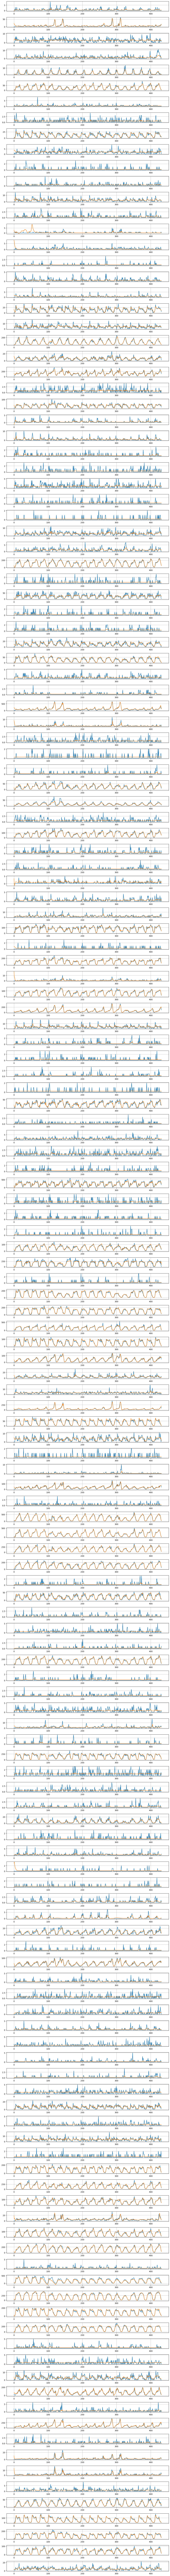

In [121]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        batch_X = batch_X.unsqueeze(dim=-1)
        batch_y = batch_y.unsqueeze(dim=-1)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)

    model.reset()
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Change the dimension to work with scaler
    test_preds = test_preds.cpu().numpy().squeeze(-1).T
    test_target = test_target.cpu().numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler.inverse_transform(test_preds)
    test_target = scaler.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 180))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        # axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()
